To get hourly data from the PVGIS API, you can use the series endpoint, which provides time series data for solar irradiance (DNI, DHI, GHI) and other meteorological parameters.

Required Parameters
- `lat`: Latitude of the location.
- `lon`: Longitude of the location.
- `startyear`: The starting year for the data.
- `endyear`: The ending year for the data.
- `outputformat`: Format of the output (json or csv).
- `usehorizon`: Whether to include horizon shading (1 for yes, 0 for no).
- `pvcalculation`: Set to 0 to get only irradiance data (no PV system calculations).
- `timeformat`: Set to 1 for hourly data.

In [23]:
import pvlib
import matplotlib.pyplot as plt
import pandas as pd

In order to get the Global Horizonal Irradiance (GHI) data hourly from PV-GIS, I found that I had to set "components" = 0. This first API request therefore gets the data for GHI.

In [ ]:
import requests

# Define the API URL and parameters
params = {
    "lat": 51.483,  # Latitude
    "lon": -1.718,  # Longitude
    "startyear": 2005,
    "endyear": 2023,
    "outputformat": "basic",  # Output format (csv or json)
    "usehorizon": 1,        # Include horizon shading
    "pvcalculation": 0,     # Only irradiance data
    "timeformat": 1,        # Hourly data
    "components": 0 ##### NO COMPONENTS: TO GET GHI ######
}

# Make the API request
response = requests.get(url, params=params)
print(response.url)

# Save the response to a CSV file
with open("data/PVGIS_hourly_data_GHI.csv", "w") as file:
    file.write(response.text)

print("Hourly data saved to PVGIS_hourly_data.csv")

https://re.jrc.ec.europa.eu/api/seriescalc?lat=51.483&lon=-1.718&startyear=2005&endyear=2023&outputformat=basic&usehorizon=1&pvcalculation=0&timeformat=1&components=1&trackingtype=0
Hourly data saved to PVGIS_hourly_data_tracker.csv


In [ ]:
Since I want to manually do the Plane of Array calculations. I will need the Direct Normal Irradiance (DNI) and Diffuse Horizontal Irradiance (DHI) values also.

I was unable to do this with a simple API call, since ticking "components" = 1 gives me the following:

- *Gb(i)*: Beam (direct) irradiance on the inclined plane (plane of the array) (W/m2)
- *Gd(i)*: Diffuse irradiance on the inclined plane (plane of the array) (W/m2)
- *Gr(i)*: Reflected irradiance on the inclined plane (plane of the array) (W/m2)

By setting "trackingtype" = 2 (2-axis tracking), I therefore use the Gb(i) = DNI, since the sun is always directly overhead. The Gd(i) value is the diffuse irradiance on the inclined plane, which I can use to calculate the diffuse fraction. The Gr(i) value is the reflected irradiance on the inclined plane, which I can ignore for now.

In [ ]:
url = "https://re.jrc.ec.europa.eu/api/seriescalc?"
params = {
    "lat": 51.483,  # Latitude
    "lon": -1.718,  # Longitude
    "startyear": 2005,
    "endyear": 2023,
    "outputformat": "basic",  # Output format (csv or json)
    "usehorizon": 1,        # Include horizon shading
    "pvcalculation": 0,     # Only irradiance data
    "timeformat": 1,        # Hourly data
    "components": 1,        
    "trackingtype": 2       # 2-axis tracking
}

# Make the API request
response = requests.get(url, params=params)
print(response.url)

# Save the response to a CSV file
with open("data/PVGIS_hourly_data_tracker.csv", "w") as file:
    file.write(response.text)

print("Hourly data saved to PVGIS_hourly_data_tracker.csv")

https://re.jrc.ec.europa.eu/api/seriescalc?lat=51.483&lon=-1.718&startyear=2005&endyear=2023&outputformat=basic&usehorizon=1&pvcalculation=0&timeformat=1&components=0
Hourly data saved to PVGIS_hourly_data.csv


In [50]:
# The April data that PV-GIS provides comes from 2007 which is the sunniest April in recent history!
# I cannot explain why this is happening but it is clear this is not a 'typical' April.
# Instead I will import all the historical hourly data from 2005 to 2023
# determine the median month for total GHI and construct my own TMY.

# import csv from PV-GIS

# Define the file paths
input_file_GHI = 'data/PVGIS_hourly_data_GHI.csv'
input_file_tracker = 'data/PVGIS_hourly_data_tracker.csv'

# Read the CSV file, skipping the first two rows and parsing dates
df_tracker = pd.read_csv(input_file_tracker, skiprows=2, parse_dates=True, index_col=0, header=None)
df_tracker.columns = ['Gb(i)','Gd(i)','Gr(i)','H_sun','T2m','WS10m','Int']
df_tracker.index = pd.to_datetime(df_tracker.index, format='%Y%m%d:%H%M')

df_GHI = pd.read_csv(input_file_GHI, skiprows=2, parse_dates=True, index_col=0, header=None)
df_GHI.columns = ['G(i)','H_sun','T2m','WS10m','Int']
df_GHI.index = pd.to_datetime(df_GHI.index, format='%Y%m%d:%H%M')


# Display the first few rows of the processed DataFrame
display(df_tracker.head(20))
display(df_GHI.head(20))

# Process the DataFrame to include only the required columns with new names
df_historical = pd.DataFrame({
    'GHI': df_GHI['G(i)'],
    'Direct Normal_Tracker': df_tracker['Gb(i)'],
    'Diffuse Horizontal_Tracker': df_tracker['Gd(i)'],
    'Temperature': df_GHI['T2m'],
    'Wind Speed': df_GHI['WS10m']
})

display(df_historical.loc['2018-01-01'])

# # Ideally would store the minute past the hour for good order.
# df_historical.index = df_historical.index.floor('h') # truncate minutes data
# df_historical.index = df_historical.index + pd.Timedelta(hours=1) # shift hour by +1 so data is End of Period.

# print(type(df_historical.index))

# # Display the first few rows of the processed DataFrame
# print(df_historical.head(40))

/var/folders/_m/h8l9pxn15fdf17mc1s6m6cxh0000gn/T/ipykernel_17345/2448993045.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_tracker = pd.read_csv(input_file_tracker, skiprows=2, parse_dates=True, index_col=0, header=None)
/var/folders/_m/h8l9pxn15fdf17mc1s6m6cxh0000gn/T/ipykernel_17345/2448993045.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_GHI = pd.read_csv(input_file_GHI, skiprows=2, parse_dates=True, index_col=0, header=None)


,Gb(i),Gd(i),Gr(i),H_sun,T2m,WS10m,Int
0,,,,,,,
2005-01-01 00:10:00,0.0,0.0,0.0,0.00,4.29,2.55,0.0
2005-01-01 01:10:00,0.0,0.0,0.0,0.00,3.98,2.62,0.0
2005-01-01 02:10:00,0.0,0.0,0.0,0.00,4.16,2.83,0.0
2005-01-01 03:10:00,0.0,0.0,0.0,0.00,4.51,3.03,0.0
2005-01-01 04:10:00,0.0,0.0,0.0,0.00,5.21,3.17,0.0
2005-01-01 05:10:00,0.0,0.0,0.0,0.00,5.94,3.31,0.0
2005-01-01 06:10:00,0.0,0.0,0.0,0.00,6.59,3.52,0.0
2005-01-01 07:10:00,0.0,0.0,0.0,0.00,6.73,3.79,0.0
2005-01-01 08:10:00,0.0,0.0,0.0,0.00,6.97,4.00,0.0


,G(i),H_sun,T2m,WS10m,Int
0,,,,,
2005-01-01 00:10:00,0.0,0.00,4.29,2.55,0.0
2005-01-01 01:10:00,0.0,0.00,3.98,2.62,0.0
2005-01-01 02:10:00,0.0,0.00,4.16,2.83,0.0
2005-01-01 03:10:00,0.0,0.00,4.51,3.03,0.0
2005-01-01 04:10:00,0.0,0.00,5.21,3.17,0.0
2005-01-01 05:10:00,0.0,0.00,5.94,3.31,0.0
2005-01-01 06:10:00,0.0,0.00,6.59,3.52,0.0
2005-01-01 07:10:00,0.0,0.00,6.73,3.79,0.0
2005-01-01 08:10:00,0.0,0.00,6.97,4.00,0.0


,GHI,Direct Normal_Tracker,Diffuse Horizontal_Tracker,Temperature,Wind Speed
0,,,,,
2018-01-01 00:10:00,0.00,0.00,0.00,5.14,6.41
2018-01-01 01:10:00,0.00,0.00,0.00,4.68,6.69
2018-01-01 02:10:00,0.00,0.00,0.00,4.60,6.97
2018-01-01 03:10:00,0.00,0.00,0.00,4.52,6.97
2018-01-01 04:10:00,0.00,0.00,0.00,5.08,7.03
2018-01-01 05:10:00,0.00,0.00,0.00,5.09,6.14
2018-01-01 06:10:00,0.00,0.00,0.00,4.89,5.38
2018-01-01 07:10:00,0.00,0.00,0.00,4.28,3.93
2018-01-01 08:10:00,0.00,0.00,0.00,4.12,3.31


In [37]:
# Calculate the GHI from the tracker data and reconcile with the GHI dataset

# make a Location object corresponding to this dataset
location = pvlib.location.Location(latitude=params['lat'],
                                   longitude=params['lon'])

# shift timestamps if necessary from the TMY file to match the solar position calculations
times = df_GHI.index
solar_position = location.get_solarposition(times)

# Calculate the poa for a horizontal panel
poa = pvlib.irradiance.get_total_irradiance(
    surface_tilt=0,  # Tilt angle
    surface_azimuth=0,  # Facing South
    dni=df_historical['Direct Normal_Tracker'],
    ghi=df_historical['GHI'],
    dhi=df_historical['Diffuse Horizontal_Tracker'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    model='isotropic'
)

display(poa.head(20))
df_poa = pd.DataFrame(poa['poa_global'])
display(df_poa.head(20))

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
0,,,,,
2005-01-01 00:10:00,0.000000,0.000000,0.00,0.00,0.0
2005-01-01 01:10:00,0.000000,0.000000,0.00,0.00,0.0
2005-01-01 02:10:00,0.000000,0.000000,0.00,0.00,0.0
2005-01-01 03:10:00,0.000000,0.000000,0.00,0.00,0.0
2005-01-01 04:10:00,0.000000,0.000000,0.00,0.00,0.0
2005-01-01 05:10:00,0.000000,0.000000,0.00,0.00,0.0
2005-01-01 06:10:00,0.000000,0.000000,0.00,0.00,0.0
2005-01-01 07:10:00,0.000000,0.000000,0.00,0.00,0.0
2005-01-01 08:10:00,0.000000,0.000000,0.00,0.00,0.0


,poa_global
0,
2005-01-01 00:10:00,0.000000
2005-01-01 01:10:00,0.000000
2005-01-01 02:10:00,0.000000
2005-01-01 03:10:00,0.000000
2005-01-01 04:10:00,0.000000
2005-01-01 05:10:00,0.000000
2005-01-01 06:10:00,0.000000
2005-01-01 07:10:00,0.000000
2005-01-01 08:10:00,0.000000


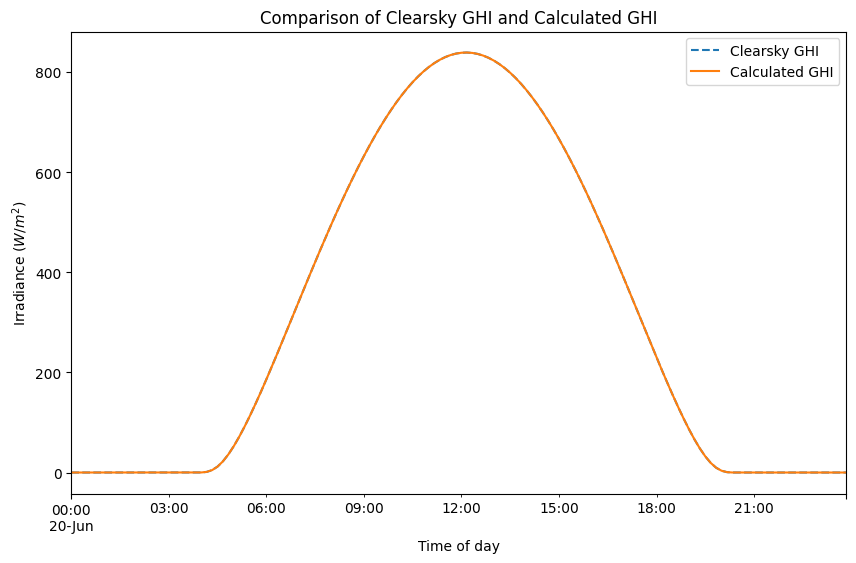

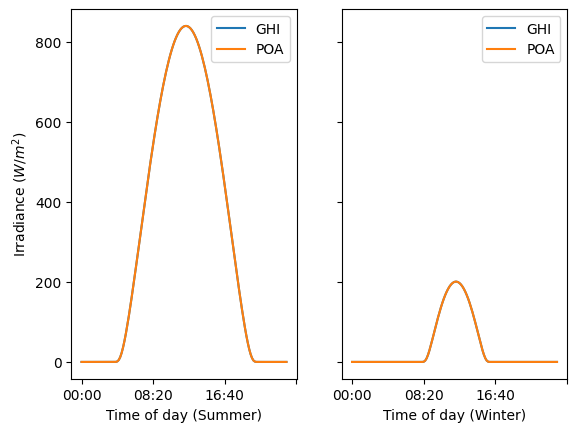

In [47]:
from pvlib import location
from pvlib import irradiance
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# For this example, we will be using Golden, Colorado
tz = 'UTC'
lat, lon = 51.483, -1.718

# Create location object to store lat, lon, timezone
site = location.Location(lat, lon, tz=tz)


# Calculate clear-sky GHI and transpose to plane of array
# Define a function so that we can re-use the sequence of operations with
# different locations
def get_irradiance(site_location, date, tilt, surface_azimuth):
    # Creates one day's worth of 10 min intervals
    times = pd.date_range(date, freq='10min', periods=6*24,
                          tz=site_location.tz)
    # Generate clearsky data using the Ineichen model, which is the default
    # The get_clearsky method returns a dataframe with values for GHI, DNI,
    # and DHI
    clearsky = site_location.get_clearsky(times)
    # Get solar azimuth and zenith to pass to the transposition function
    solar_position = site_location.get_solarposition(times=times)
    # Use the get_total_irradiance function to transpose the GHI to POA
    POA_irradiance = irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=surface_azimuth,
        dni=clearsky['dni'],
        ghi=clearsky['ghi'],
        dhi=clearsky['dhi'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'])
    # Return DataFrame with only GHI and POA
    return pd.DataFrame({'GHI': clearsky['ghi'],
                         'POA': POA_irradiance['poa_global']})

def get_irradiance_JH(site_location, date, tilt, surface_azimuth):
    # Creates one day's worth of 10 min intervals
    times = pd.date_range(date, freq='10min', periods=6*24,
                          tz=site_location.tz)
    # Generate clearsky data using the Ineichen model, which is the default
    clearsky = site_location.get_clearsky(times)
    # Get solar azimuth and zenith to pass to the transposition function
    solar_position = site_location.get_solarposition(times=times)
    # Calculate GHI using DNI and DHI with cos(theta_z)
    calculated_ghi = clearsky['dni'] * np.cos(np.radians(solar_position['apparent_zenith'])) + clearsky['dhi']
    # Add the calculated GHI as a new column
    clearsky['calculated_ghi'] = calculated_ghi
    # Return DataFrame with DNI, GHI, DHI, and calculated GHI
    return clearsky[['dni', 'ghi', 'dhi', 'calculated_ghi']]

# Example usage
irradiance_data = get_irradiance_JH(site, '06-20-2020', 30, 0)

# Plot GHI from clearsky vs calculated GHI
plt.figure(figsize=(10, 6))
irradiance_data['ghi'].plot(label='Clearsky GHI', linestyle='--')
irradiance_data['calculated_ghi'].plot(label='Calculated GHI', linestyle='-')
plt.xlabel('Time of day')
plt.ylabel('Irradiance ($W/m^2$)')
plt.title('Comparison of Clearsky GHI and Calculated GHI')
plt.legend()
plt.show()


# Get irradiance data for summer and winter solstice, assuming 25 degree tilt
# and a south facing array
summer_irradiance = get_irradiance(site, '06-20-2020', 0, 0)
winter_irradiance = get_irradiance(site, '12-21-2020', 0, 0)

# Convert Dataframe Indexes to Hour:Minute format to make plotting easier
summer_irradiance.index = summer_irradiance.index.strftime("%H:%M")
winter_irradiance.index = winter_irradiance.index.strftime("%H:%M")

# Plot GHI vs. POA for winter and summer
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
summer_irradiance['GHI'].plot(ax=ax1, label='GHI')
summer_irradiance['POA'].plot(ax=ax1, label='POA')
winter_irradiance['GHI'].plot(ax=ax2, label='GHI')
winter_irradiance['POA'].plot(ax=ax2, label='POA')
ax1.set_xlabel('Time of day (Summer)')
ax2.set_xlabel('Time of day (Winter)')
ax1.set_ylabel('Irradiance ($W/m^2$)')
ax1.legend()
ax2.legend()
plt.show()

